In [1]:
import numpy as np
from scipy import optimize
from numba import vectorize, float32, float64
import torch
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])

import sys
sys.path.insert(0, '../src/pydftlj/')
from dft3dgpu import dft3d
from eos import LJEOS 

from pymatgen.core import Structure
from pymatgen.analysis import structure_matcher

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-05-22

In [2]:
kB = 1.380649e-23 # J/K
Rconst = 0.082057366080960 # Gas constant
NA = 6.022e23 # Avogadro number

## Solid CIF file Information

In [3]:
structure_name = 'aCarbon-Bhatia-id001'
structure = Structure.from_file('../structures/'+structure_name+'.cif')
print('formula:  ', structure.formula)
print('num_sites:', structure.num_sites)

formula:   C1166
num_sites: 1166


In [4]:
coordinates = structure.cart_coords.T
Lsolid = np.array([l for l in structure.lattice.lengths])
print('Solid dimensions: ', Lsolid)
Vsolid = Lsolid[0]*Lsolid[1]*Lsolid[2]
print('Solid volume: ', Vsolid, ' A³')

Solid dimensions:  [29.5 29.8 30.2]
Solid volume:  26548.82  A³


In [5]:
print('x: ',structure.cart_coords[:,0].min(),structure.cart_coords[:,0].max())
print('y: ',structure.cart_coords[:,1].min(),structure.cart_coords[:,1].max())
print('z: ',structure.cart_coords[:,2].min(),structure.cart_coords[:,2].max())

x:  0.005015000000002582 29.47699
y:  0.024912800000000002 29.6384542
z:  0.04167600000000065 30.1975538


# Force Field for solid-fluid interaction

In [6]:
forcefield_name = 'DREIDING'
forcefield = pd.read_csv('../parameters/'+forcefield_name+'-forcefield.dat',delim_whitespace=True)
forcefield

,atom,sigma/AA,epsilon/kB,mass/u
0,H,2.84642,7.64893,1.00784
1,C,3.47299,47.85620,12.01070
2,N,3.26256,38.94920,14.00670
3,O,3.03315,48.15810,15.99900
4,Cu,3.11369,2.51610,63.54600
5,Zn,4.04468,27.67710,65.38000


# Fluid Information

In [7]:
# PCSAFT: Gross, J., & Sadowski, G. (2001). Industrial & Engineering Chemistry Research, 40(4), 1244–1260.
# TraPPE: M.G. Martin, and J.I. Siepmann, J. Phys. Chem. B 102, 2569-2577 (1998).
# SoftSAFT: Blas, F. J., & Vega, L. F. (1998). Industrial and Engineering Chemistry Research, 5885(1996), 660–674.
fluid_molecule = 'CH4'
epsilon = {'TraPPE': 148.0, 'PCSAFT': 150.03, 'SoftSAFT': 147.302}
sigma = {'TraPPE': 3.73, 'PCSAFT': 3.704, 'SoftSAFT': 3.722}

fluid_forcefield = 'TraPPE'
epsilonff = epsilon[fluid_forcefield] # kelvin
sigmaff = sigma[fluid_forcefield] # angstrom
mff = 16.043

In [8]:
#Helium parameters for pycnometer
epsilonHe = 10.22 # kelvin
sigmaHe = 2.58  # angstrom

# Create the DFT object

In [9]:
Ncell = 128

In [10]:
DFT = dft3d(gridsize=np.array([Ncell,Ncell,Ncell]),ljmethod='MMFA',padding=True,padding_value='bulk')
DFT.Set_FluidProperties(sigma=sigmaff,epsilon=epsilonff)
DFT.Set_Geometry(Lsolid)

In [11]:
DFT.GetSystemInformation()

============== The DFT 3D for LJ fluids ==============
Methods:
HS method =  WBI
LJ method =  MMFA
The grid is [218 217 216]
--- Geometry properties ---
Lx = 50.182104  A
Ly = 50.48210400000001  A
Lz = 50.882104  A
delta =  [0.23046875 0.2328125  0.2359375 ]  A
Vol = 128899.54212263784  A³


In [12]:
DFT.GetFluidInformation()

--- Fluid properties ---
epsilon/kB = 148.0  K
sigma = 3.73  A


## Generating the External Potential

In [13]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

In [14]:
%%time

mss = 0.0

Vext = np.zeros((DFT.Ngrid[0],DFT.Ngrid[1],DFT.Ngrid[2]))
Vext_helium = np.zeros((DFT.Ngrid[0],DFT.Ngrid[1],DFT.Ngrid[2]))

# Lorentz-Berthelot combination rule
for i, site in enumerate(structure):
    sigmasf = float(0.5*(sigmaff+forcefield["sigma/AA"][forcefield["atom"]==site.species_string]))
    epsilonsf = float(np.sqrt(epsilonff*forcefield["epsilon/kB"][forcefield["atom"]==site.species_string]))
    mss += float(forcefield["mass/u"][forcefield["atom"]==site.species_string])

    R = np.sqrt((DFT.X-structure.cart_coords[i,0]+0.5*Lsolid[0])**2 + (DFT.Y-structure.cart_coords[i,1]+0.5*Lsolid[1])**2 + (DFT.Z-structure.cart_coords[i,2]+0.5*Lsolid[2])**2)
    Vext[:] += ljpotential(R,epsilonsf,sigmasf)

    sigmasHe = float(0.5*(sigmaHe+forcefield["sigma/AA"][forcefield["atom"]==site.species_string]))
    epsilonsHe = float(np.sqrt(epsilonHe*forcefield["epsilon/kB"][forcefield["atom"]==site.species_string]))

    Vext_helium[:] += ljpotential(R,epsilonsHe,sigmasHe)

del R

DFT.Set_External_Potential(Vext)

CPU times: user 2min 36s, sys: 39.7 s, total: 3min 16s
Wall time: 3min 16s


In [15]:
print('Solid mass: ', mss, ' u')

Solid mass:  14004.476200000261  u


In [16]:
rhocr = 1e27*mss/(Vsolid*NA) #kg/m3 crystal density

In [17]:
print('Crystal Density: ',rhocr,' kg/m3')

Crystal Density:  875.9531841395798  kg/m3


## Defining the Temperature

In [18]:
kT = 298.0 # kelvin 
DFT.Set_Temperature(kT)

In [19]:
DFT.GetFluidTemperatureInformation()

Temperature = 298.0  K
Baker-Henderson diameter = 3.568  A


In [20]:
Vpore_calc = np.exp(-Vext_helium/298.15).sum()*DFT.dV-(DFT.Vol-Vsolid)
Vpore_fluid = np.exp(-DFT.beta*Vext).sum()*DFT.dV-(DFT.Vol-Vsolid)

print(f'Calculated pore volume for He atom is {Vpore_calc} A³')
print(f'Calculated pore volume for the fluid is {Vpore_fluid} A³')

Calculated pore volume for He atom is 16738.23713662903 A³
Calculated pore volume for the fluid is 3568157.1972907204 A³


In [21]:
helium_fraction = Vpore_calc/Vsolid

print(f'Calculated He void fraction is {helium_fraction:1.3f}')

Calculated He void fraction is 0.630


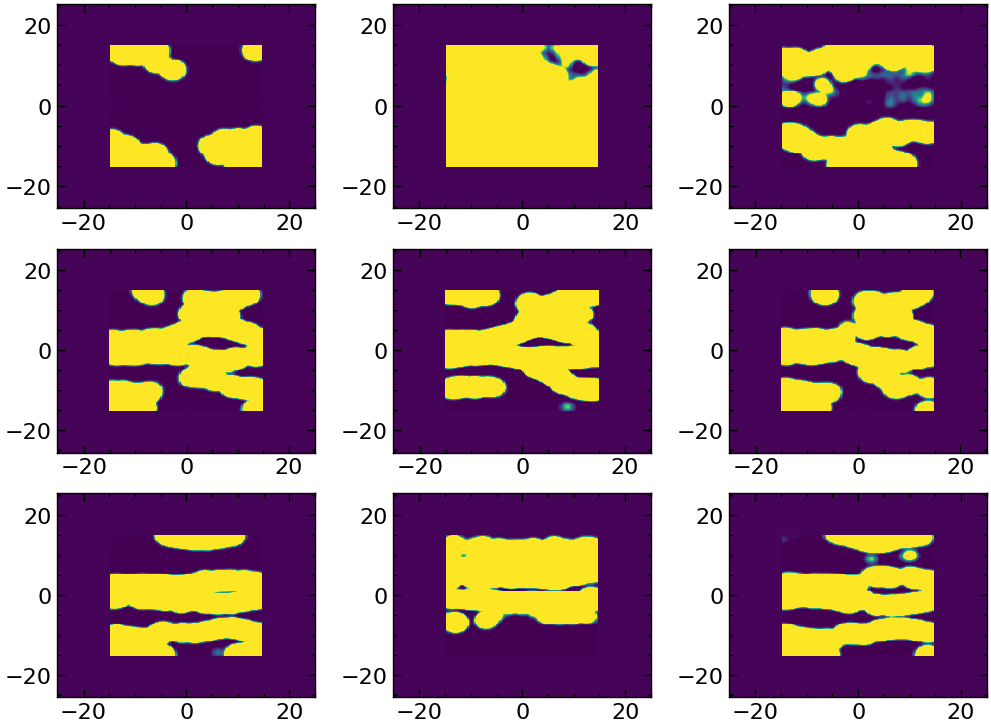

In [22]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))
plt.subplots_adjust(hspace=0.2,wspace=0.3)

axs[0,0].pcolormesh(DFT.X[:,:,DFT.Npad[2]+1],DFT.Y[:,:,DFT.Npad[2]+1],DFT.Vext[:,:,DFT.Npad[2]+1].cpu(), cmap='viridis',vmin=-1e2,vmax=1e4)
axs[0,1].pcolormesh(DFT.X[:,:,DFT.Ngrid[2]//2],DFT.Y[:,:,DFT.Ngrid[2]//2],DFT.Vext[:,:,DFT.Ngrid[2]//2].cpu(), cmap='viridis',vmin=-1e2,vmax=1e4)
axs[0,2].pcolormesh(DFT.X[:,:,-(DFT.Npad[2]+1)],DFT.Y[:,:,-(DFT.Npad[2]+1)],DFT.Vext[:,:,-(DFT.Npad[2]+1)].cpu(), cmap='viridis',vmin=-1e2,vmax=1e4)
axs[1,0].pcolormesh(DFT.Y[(DFT.Npad[0]+1),:,:],DFT.Z[(DFT.Npad[0]+1),:,:],DFT.Vext[(DFT.Npad[0]+1),:,:].cpu(), cmap='viridis',vmin=-1e2,vmax=1e4)
axs[1,1].pcolormesh(DFT.Y[DFT.Ngrid[0]//2,:,:],DFT.Z[DFT.Ngrid[0]//2,:,:],DFT.Vext[DFT.Ngrid[0]//2,:,:].cpu(), cmap='viridis',vmin=-1e2,vmax=1e4)
axs[1,2].pcolormesh(DFT.Y[-(DFT.Npad[0]+1),:,:],DFT.Z[-(DFT.Npad[0]+1),:,:],DFT.Vext[-(DFT.Npad[0]+1),:,:].cpu(), cmap='viridis',vmin=-1e2,vmax=1e4)
axs[2,0].pcolormesh(DFT.X[:,(DFT.Npad[1]+1),:],DFT.Z[:,(DFT.Npad[1]+1),:],DFT.Vext[:,(DFT.Npad[1]+1),:].cpu(), cmap='viridis',vmin=-1e2,vmax=1e4)
axs[2,1].pcolormesh(DFT.X[:,DFT.Ngrid[1]//2,:],DFT.Z[:,DFT.Ngrid[1]//2,:],DFT.Vext[:,DFT.Ngrid[1]//2,:].cpu(), cmap='viridis',vmin=-1e2,vmax=1e4)
axs[2,2].pcolormesh(DFT.X[:,-(DFT.Npad[1]+1),:],DFT.Z[:,-(DFT.Npad[1]+1),:],DFT.Vext[:,-(DFT.Npad[1]+1),:].cpu(), cmap='viridis',vmin=-1e2,vmax=1e4)

In [23]:
ljeos= LJEOS(sigma=sigmaff,epsilon=epsilonff,model='MBWR')

In [24]:
def rhofromBARpressure(pbar):
    def func(x,p):
        return ljeos.p(x,kT)-p,ljeos.dpdrho(x,kT), ljeos.d2pdrho2(x,kT)
    if np.isscalar(pbar):
        sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar/(1e-5*kB)), method='halley')
        rho = sol.root
    else:
        rho = np.empty_like(pbar)
        sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar[0]/(1e-5*kB)), method='halley')
        rho[0] = sol.root
        for i in range(1,pbar.size):
            sol = optimize.root_scalar(func, x0=rho[i-1], fprime=True,fprime2=True,args=(1e-30*pbar[i]/(1e-5*kB)), method='halley')
            rho[i] = sol.root
    return rho

In [25]:
# pbararray = np.hstack((np.array([1e-4,1e-3,1e-2]),np.arange(0.05,2.0,0.05),np.arange(2.,101,1.0),np.arange(110,510,10.0),np.arange(600,1100,100.0))) # bulk pressure (in bar)
pbararray = np.hstack((np.arange(0.05,2.0,0.05),np.arange(2.,101,1.0),np.arange(110,510,10.0))) # bulk pressure (in bar)

In [26]:
rhobarray = rhofromBARpressure(pbararray)

In [27]:
bulkMC = pd.read_pickle('data/MC/Lucas/methane_300K.pickle')

(0.0, 500.0)

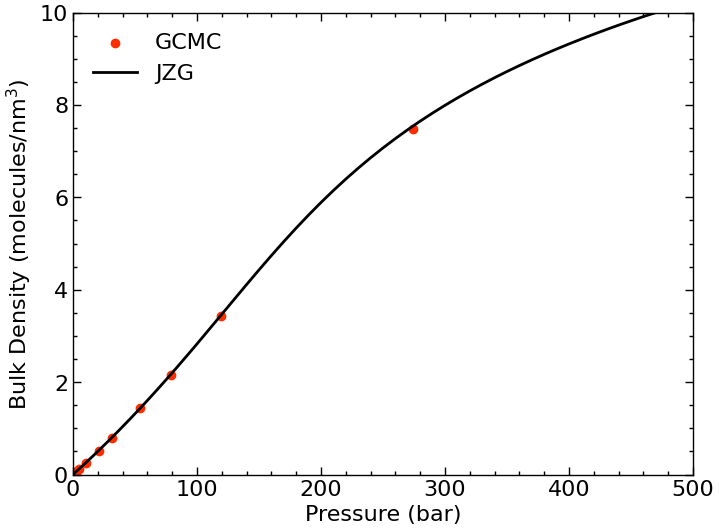

In [28]:
plt.scatter(bulkMC['Pressure (bar)'],bulkMC['Density (kg/m3)']*(NA*1e-27)/(1e-3*mff),color='C3',label='GCMC')
plt.plot(pbararray,rhobarray*1e3,color='k',label='JZG')
plt.xlabel(r'Pressure (bar)')
plt.ylabel(r'Bulk Density (molecules/nm$^{3}$)')
plt.legend(loc='best')
plt.ylim(0,10)
plt.xlim(0,500)
# plt.xscale('log')
# plt.yscale('log')

In [29]:
%%time

Nbulkarray = np.zeros_like(rhobarray)
Nidearray = np.zeros_like(rhobarray)
Nadsarray = np.zeros_like(rhobarray)
Nexcarray = np.zeros_like(rhobarray)

DFT.Set_BulkDensity(rhobarray[0])
DFT.Set_InitialCondition()

print('P (bar)\t rhob (AA^-3)\t Nbulk(molecules/u.c.)\t Nid(molecules/u.c.)\t Nabs(molecules/u.c.)\t Nexc(molecules/u.c.)\t dt')

for i in range(rhobarray.size):
    rhob = rhobarray[i]

    DFT.Set_BulkDensity(rhob)

    DFT.Calculate_Equilibrium(alpha0=0.25,dt=0.005,atol=1.e-6,rtol=1e-5,method='fire',logoutput=False)
    
    if pbararray[i] == 0.1 or pbararray[i] == 1.0 or pbararray[i] == 10.0 or pbararray[i] == 100.0:
        np.save('dft-profiles-'+structure_name+'-'+fluid_molecule+'-'+fluid_forcefield+'-'+forcefield_name+'-T='+str(kT)+'K-N='+str(Ncell)+'-ljmethod='+str(DFT.ljmethod)+'-P='+str(pbararray[i])+'bar.npy',[DFT.X,DFT.Y,DFT.Z,DFT.rho.cpu().numpy()])

    Nbulkarray[i] = DFT.rhob*Vpore_calc
    Nidearray[i] = DFT.rhob*Vpore_fluid
    Nadsarray[i] = DFT.Nabs-DFT.rhob*(DFT.Vol-Vsolid)
    Nexcarray[i] = Nadsarray[i] - Nbulkarray[i]
    print(pbararray[i].round(3),rhob,Nbulkarray[i].round(4),Nidearray[i].round(4),Nadsarray[i].round(4),Nexcarray[i].round(4),DFT.dt.cpu().numpy().round(4))

/home/elvis/Google Drive/Projetos em Andamento/2-DFT in Amorphous Carbon/codes/PyDFTlj/examples/../src/pydftlj/dft3dgpu.py:276: RuntimeWarning: invalid value encountered in dphi3dnfuncWBI
  self.dphi3dn3 = torch.tensor(dphi3dnfuncWBI(self.n3.numpy()),dtype=torch.float32)


P (bar)	 rhob (AA^-3)	 Nbulk(molecules/u.c.)	 Nid(molecules/u.c.)	 Nabs(molecules/u.c.)	 Nexc(molecules/u.c.)	 dt
0.05 1.215362540699416e-06 0.0203 4.3366 2.6487 2.6283 0.005
0.1 2.430923153022343e-06 0.0407 8.6739 4.2756 4.2349 0.005
0.15 3.6466818505187545e-06 0.061 13.0119 5.5585 5.4975 0.005
0.2 4.8626386467451845e-06 0.0814 17.3507 6.6513 6.57 0.005
0.25 6.078793555264702e-06 0.1017 21.6901 7.6193 7.5176 0.005
0.3 7.295146589646877e-06 0.1221 26.0302 8.4968 8.3747 0.005
0.35 8.511697763467753e-06 0.1425 30.3711 9.3073 9.1648 0.005
0.4 9.72844709030981e-06 0.1628 34.7126 10.064 9.9012 0.005
0.45 1.0945394583761948e-05 0.1832 39.0549 10.7761 10.5929 0.005
0.5 1.2162540257419439e-05 0.2036 43.3979 11.4523 11.2487 0.005
0.55 1.3379884124883905e-05 0.224 47.7415 12.0968 11.8728 0.005
0.6 1.4597426199763286e-05 0.2443 52.0859 12.715 12.4707 0.005
0.65 1.581516649567182e-05 0.2647 56.431 13.3093 13.0446 0.005
0.7 1.7033105026229973e-05 0.2851 60.7768 13.8835 13.5984 0.005
0.75 1.82512418

In [ ]:
rhomax = 0.2*DFT.rho[:,:,:].max().numpy()

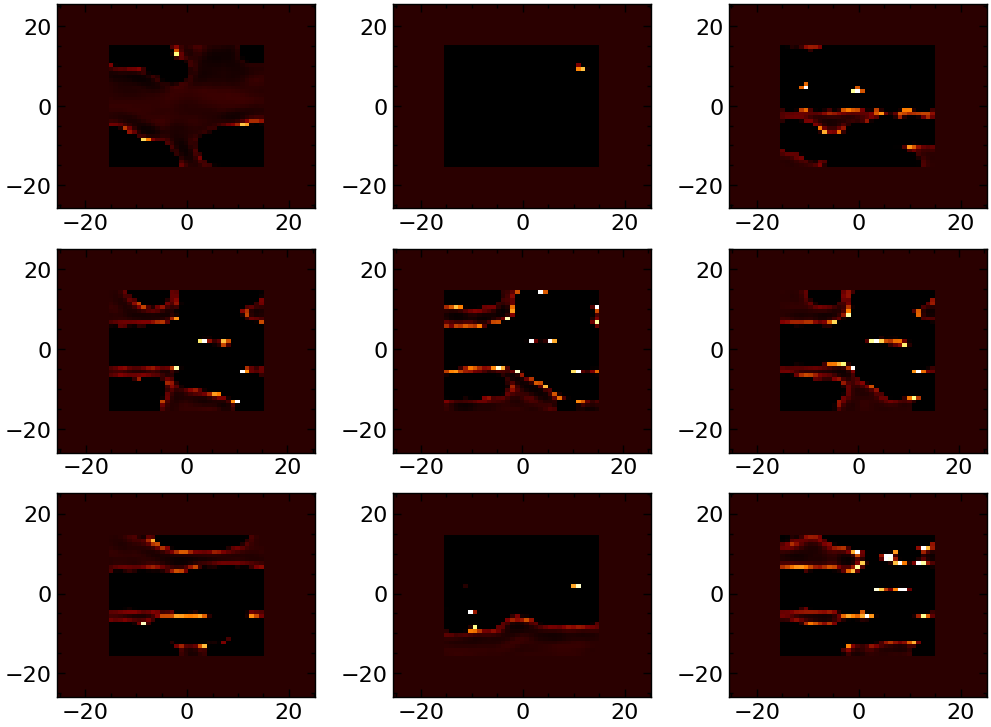

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 9))
plt.subplots_adjust(hspace=0.2,wspace=0.3)

colormp = 'afmhot'

axs[0,0].pcolormesh(DFT.X[:,:,DFT.Npad[2]+1],DFT.Y[:,:,DFT.Npad[2]+1],DFT.rho[:,:,DFT.Npad[2]+1].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[0,1].pcolormesh(DFT.X[:,:,DFT.Ngrid[2]//2],DFT.Y[:,:,DFT.Ngrid[2]//2],DFT.rho[:,:,DFT.Ngrid[2]//2].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[0,2].pcolormesh(DFT.X[:,:,-(DFT.Npad[2]+1)],DFT.Y[:,:,-(DFT.Npad[2]+1)],DFT.rho[:,:,-(DFT.Npad[2]+1)].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[1,0].pcolormesh(DFT.Y[(DFT.Npad[0]+1),:,:],DFT.Z[(DFT.Npad[0]+1),:,:],DFT.rho[(DFT.Npad[0]+1),:,:].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[1,1].pcolormesh(DFT.Y[DFT.Ngrid[0]//2,:,:],DFT.Z[DFT.Ngrid[0]//2,:,:],DFT.rho[DFT.Ngrid[0]//2,:,:].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[1,2].pcolormesh(DFT.Y[-(DFT.Npad[0]+1),:,:],DFT.Z[-(DFT.Npad[0]+1),:,:],DFT.rho[-(DFT.Npad[0]+1),:,:].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[2,0].pcolormesh(DFT.X[:,(DFT.Npad[1]+1),:],DFT.Z[:,(DFT.Npad[1]+1),:],DFT.rho[:,(DFT.Npad[1]+1),:].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[2,1].pcolormesh(DFT.X[:,DFT.Ngrid[1]//2,:],DFT.Z[:,DFT.Ngrid[1]//2,:],DFT.rho[:,DFT.Ngrid[1]//2,:].cpu(), cmap=colormp,vmin=0,vmax=rhomax)
axs[2,2].pcolormesh(DFT.X[:,-(DFT.Npad[1]+1),:],DFT.Z[:,-(DFT.Npad[1]+1),:],DFT.rho[:,-(DFT.Npad[1]+1),:].cpu(), cmap=colormp,vmin=0,vmax=rhomax)

Text(0, 0.5, '$\\rho/\\rho_b$')

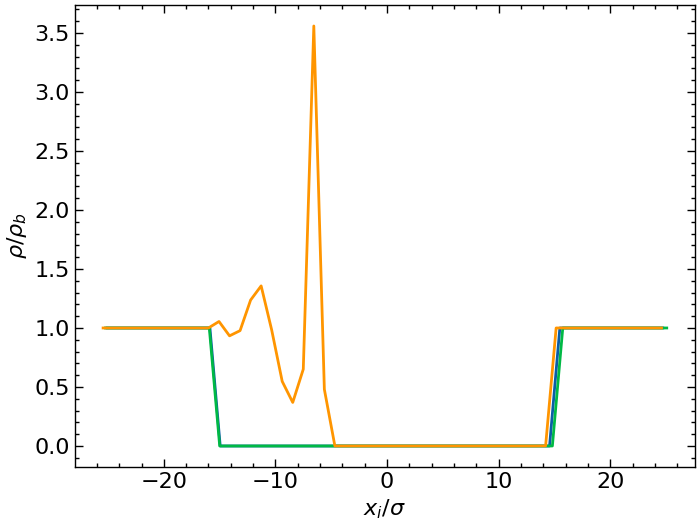

In [ ]:
plt.plot(DFT.X[:,DFT.Ngrid[1]//2,DFT.Ngrid[2]//2],DFT.rho[:,DFT.Ngrid[1]//2,DFT.Ngrid[2]//2].cpu()/rhob)
plt.plot(DFT.Y[DFT.Ngrid[0]//2,:,DFT.Ngrid[2]//2],DFT.rho[DFT.Ngrid[0]//2,:,DFT.Ngrid[2]//2].cpu()/rhob)
plt.plot(DFT.Z[DFT.Ngrid[0]//2,DFT.Ngrid[1]//2,:],DFT.rho[DFT.Ngrid[0]//2,DFT.Ngrid[1]//2,:].cpu()/rhob)
plt.xlabel(r'$x_i/\sigma$')
plt.ylabel(r'$\rho/\rho_b$')

In [ ]:
Marray = mff*Nadsarray

Nbulkarray = rhobarray*Vpore_calc
Mbulk = mff*Nbulkarray

In [ ]:
Midealarray = mff*Nidearray
Mexcarray = Nexcarray*mff

In [ ]:
df = pd.DataFrame()
df['Pressure (bar)'] = pbararray
df['Bulk adsorption (molecules/uc)'] = Nbulkarray
df['Bulk adsorption (molecules/nm^3)'] = Nbulkarray/(Vsolid*1e-3)
df['Bulk adsorption (%w.t.)'] = 100*Mbulk/(mss+Mbulk)
df['Bulk adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/1e5)*Nbulkarray/Vsolid 
df['Bulk adsorption (mol/kg)'] = 1e3*Nbulkarray/mss
df['Ideal adsorption (molecules/uc)'] = Nidearray
df['Ideal adsorption (molecules/nm^3)'] = Nidearray/(Vsolid*1e-3)
df['Ideal adsorption (%w.t.)'] = 100*Midealarray/(mss+Midealarray)
df['Ideal adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/1e5)*Nidearray/Vsolid
df['Ideal adsorption (mol/kg)'] = 1e3*Nidearray/mss
df['Absolute adsorption (molecules/uc)'] = Nadsarray
df['Absolute adsorption (molecules/nm^3)'] = Nadsarray/(Vsolid*1e-3)
df['Absolute adsorption (mg/g)'] = 1e3*Marray/mss
df['Absolute adsorption (%w.t.)'] = 100*Marray/(mss+Marray)
df['Absolute adsorption (mol/kg)'] = 1e3*Nadsarray/mss
df['Absolute adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/1e5)*Nadsarray/Vsolid # STP 0ºC and 1e5 Pa (IUPAC since 1982)
df['Excess adsorption (molecules/uc)'] = Nexcarray
df['Excess adsorption (molecules/nm^3)'] = Nexcarray/(Vsolid*1e-3)
df['Excess adsorption (mg/g)'] = 1e3*Mexcarray/mss
df['Excess adsorption (%w.t.)'] = 100*Mexcarray/(mss+Mexcarray)
df['Excess adsorption (mol/kg)'] = 1e3*Nexcarray/mss
df['Excess adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/1e5)*Nexcarray/Vsolid

In [ ]:
df.head()

,Pressure (bar),Bulk adsorption (molecules/uc),Bulk adsorption (molecules/nm^3),Bulk adsorption (%w.t.),Bulk adsorption (cm^3 STP/cm^3),Bulk adsorption (mol/kg),Ideal adsorption (molecules/uc),Ideal adsorption (molecules/nm^3),Ideal adsorption (%w.t.),Ideal adsorption (cm^3 STP/cm^3),...,Absolute adsorption (mg/g),Absolute adsorption (%w.t.),Absolute adsorption (mol/kg),Absolute adsorption (cm^3 STP/cm^3),Excess adsorption (molecules/uc),Excess adsorption (molecules/nm^3),Excess adsorption (mg/g),Excess adsorption (%w.t.),Excess adsorption (mol/kg),Excess adsorption (cm^3 STP/cm^3)
0,0.05,0.024016,0.000905,0.002751,0.034115,0.001715,5.239885,0.197368,0.596680,7.443222,...,3.216392,0.320608,0.200486,3.988315,2.783681,0.104851,3.188880,0.317874,0.198771,3.954201
1,0.10,0.048036,0.001809,0.005503,0.068235,0.003430,10.480623,0.394768,1.186377,14.887658,...,5.075925,0.505029,0.316395,6.294131,4.382911,0.165089,5.020897,0.499581,0.312965,6.225896
2,0.15,0.072060,0.002714,0.008254,0.102360,0.005145,15.722216,0.592200,1.769213,22.333306,...,6.538597,0.649612,0.407567,8.107839,5.635703,0.212277,6.456048,0.641464,0.402422,8.005479
3,0.20,0.096087,0.003619,0.011006,0.136491,0.006861,20.964662,0.789665,2.345307,29.780168,...,7.784436,0.772431,0.485223,9.652675,6.699209,0.252335,7.674362,0.761591,0.478362,9.516184
4,0.25,0.120119,0.004524,0.013758,0.170628,0.008577,26.207963,0.987161,2.914776,37.228243,...,8.889690,0.881136,0.554116,11.023187,7.639991,0.287771,8.752086,0.867615,0.545539,10.852558


(0.0, 100.0)

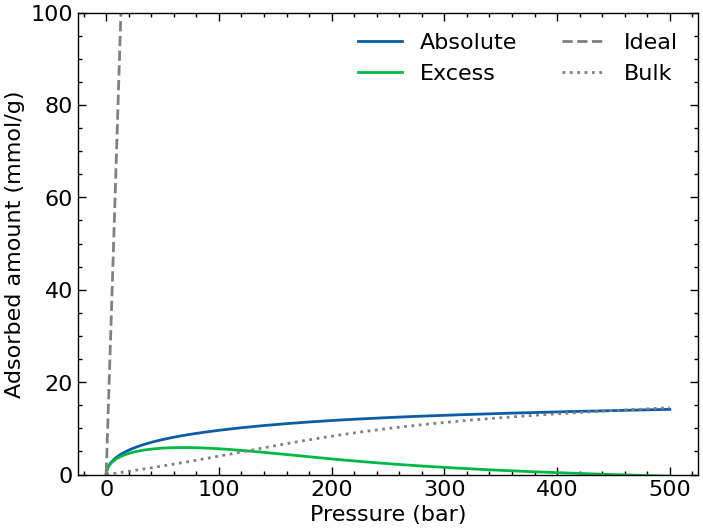

In [ ]:
plt.plot(df['Pressure (bar)'],df['Absolute adsorption (mol/kg)'],label='Absolute')
plt.plot(df['Pressure (bar)'],df['Excess adsorption (mol/kg)'],label='Excess')
plt.plot(df['Pressure (bar)'],df['Ideal adsorption (mol/kg)'],'--',color='grey',label='Ideal')
plt.plot(df['Pressure (bar)'],df['Bulk adsorption (mol/kg)'],':',color='grey',label='Bulk')
plt.legend(loc='best',ncol=2)
plt.ylabel('Adsorbed amount (mmol/g)')
plt.xlabel('Pressure (bar)')
plt.ylim(0,100)

In [ ]:
df.to_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-'+fluid_forcefield+'-'+forcefield_name+'-T='+str(kT)+'K-N='+str(Ncell)+'-ljmethod='+str(DFT.ljmethod)+'.dat', index=False,sep='\t')

In [ ]:
# dft200K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=200.0K-N=64-ljmethod=MMFA.dat',sep='\t')
# dft240K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=240.0K-N=64-ljmethod=MMFA.dat',sep='\t')
# dft270K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=270.0K-N=64-ljmethod=MMFA.dat',sep='\t')
# dft300K_data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-Steele-T=298.0K-N=32-ljmethod=MMFA.dat',sep='\t')
# dft300K_data128 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=298.0K-N=128-ljmethod=MMFA.dat',sep='\t')

# dft200K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=200.0K-N=32-ljmethod=MMFA.dat',sep='\t')
# dft300K_dataUFF = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-UFF-T=298.0K-N=32-ljmethod=MMFA.dat',sep='\t')
# dft270K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=270.0K-N=32-ljmethod=MMFA.dat',sep='\t')
# dft300K_data32 = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-TraPPE-DREIDING-T=298.0K-N=32-ljmethod=MMFA.dat',sep='\t')

In [ ]:
GCMC = pd.read_pickle('data/MC/Lucas/methane_acarbon-bhatia-id001_300K.pickle')

In [ ]:
GCMC

,Pressure (bar),Pressure std,Absolute adsorption (molecules/uc),Absolute adsorption std
0,0.009982,0.124385,1.520451,0.128012
1,0.087337,0.363996,9.618184,0.534340
2,0.510097,0.910020,25.952030,1.050601
3,1.000713,1.260001,37.347783,1.376736
4,2.006529,1.773481,52.071881,1.709118
5,2.975192,2.329853,62.159054,1.851708
6,5.172950,3.104991,76.273800,2.200315
7,10.202749,4.522383,96.799632,2.560511
8,20.600247,6.961808,117.729324,2.757259
9,31.587072,9.830944,129.263418,2.914338


# Plotting the results

(0.0, 200.0)

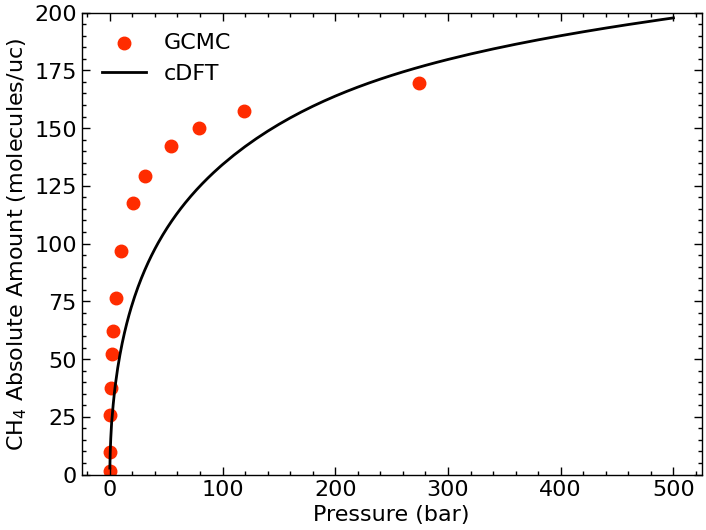

In [ ]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(GCMC['Pressure (bar)'],GCMC['Absolute adsorption (molecules/uc)'],marker='o',color='C3',label='GCMC')

# plt.plot(dft300K_data32['Pressure (bar)'],dft300K_data32['Absolute adsorption (molecules/uc)'],':',color='k',label='cDFT-32$^3$')
# plt.plot(dft300K_dataUFF['Pressure (bar)'],dft300K_dataUFF['Absolute adsorption (molecules/uc)'],':',color='k')
# plt.plot(dft200K_data32['Pressure (bar)'],dft200K_data32['Absolute adsorption (mg/g)'],':',color='k')

# plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Absolute adsorption (molecules/uc)'],'--',color='k',label='cDFT-64$^3$')
# plt.plot(dft240K_data['Pressure (bar)'],dft240K_data['Absolute adsorption (%w.t.)'],'-',color='k')
# plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Absolute adsorption (%w.t.)'],'-',color='k')
# plt.plot(dft200K_data['Pressure (bar)'],dft200K_data['Absolute adsorption (%w.t.)'],'-',color='k')

# plt.plot(dft300K_data128['Pressure (bar)'],dft300K_data128['Absolute adsorption (mg/g)'],'-',color='k',label='cDFT-128$^3$')

plt.plot(df['Pressure (bar)'],df['Absolute adsorption (molecules/uc)'],'-',color='k',label='cDFT')

plt.legend(loc='upper left')
plt.xlabel('Pressure (bar)')
plt.ylabel('CH$_4$ Absolute Amount (molecules/uc)')
# plt.xscale('log')
# plt.xlim(0,20)
plt.ylim(0,200)
# plt.xlim(0,30)

In [ ]:
rhobMC = rhofromBARpressure(GCMC['Pressure (bar)'])

(0.0, 120.0)

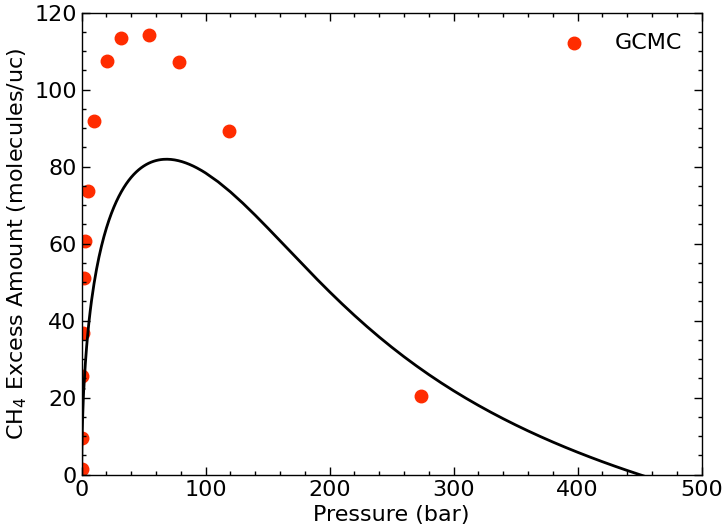

In [ ]:
plt.rcParams["lines.markersize"] = 9

plt.scatter(GCMC['Pressure (bar)'],(GCMC['Absolute adsorption (molecules/uc)']-rhobMC*helium_fraction*Vsolid),marker='o',color='C3',label='GCMC')

# plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Excess adsorption (mg/g)'],'--',color='k',label='cDFT-64$^3$')
# plt.plot(dft270K_data['Pressure (bar)'],dft270K_data['Excess adsorption (%w.t.)'],'-',color='k')
# plt.plot(dft300K_data['Pressure (bar)'],dft300K_data['Excess adsorption (%w.t.)'],'-',color='k')
# plt.plot(dft200K_data['Pressure (bar)'],dft200K_data['Excess adsorption (%w.t.)'],'-',color='k')

# plt.plot(dft300K_data32['Pressure (bar)'],dft300K_data32['Excess adsorption (mg/g)'],':',color='k',label='cDFT-32$^3$')
# plt.plot(dft300K_dataUFF['Pressure (bar)'],dft300K_dataUFF['Excess adsorption (mg/g)'],':',color='k')
# plt.plot(dft200K_data32['Pressure (bar)'],dft200K_data32['Excess adsorption (mg/g)'],':',color='k')

# plt.plot(dft300K_data128['Pressure (bar)'],dft300K_data128['Excess adsorption (mg/g)'],'-',color='k',label='cDFT-128$^3$')

plt.plot(df['Pressure (bar)'],df['Excess adsorption (molecules/uc)'],'-',color='k')

plt.legend(loc='upper right')
plt.xlabel('Pressure (bar)')
plt.ylabel('CH$_4$ Excess Amount (molecules/uc)')
# plt.xscale('log')
plt.xlim(0.0,500)
plt.ylim(0,120)